### Import required libraries


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression 
import numpy as np 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from scipy.signal import find_peaks, peak_widths
from scipy.fftpack import fft
import seaborn as sns
import matplotlib.pyplot as plt


### Load training and test datasets


In [2]:
input_train_df = pd.read_csv("C:/Users/ahmed/OneDrive/Bureau/DCI MASTER S2/datasets/InputTrain.csv")
label_df = pd.read_csv("C:/Users/ahmed/OneDrive/Bureau/DCI MASTER S2/datasets/StepOne_LabelTrain.csv")  
input_test_df = pd.read_csv("C:/Users/ahmed/OneDrive/Bureau/DCI MASTER S2/datasets/InputTest.csv")

### Load data, preprocess, extract features, train XGBoost model for the dishwasher, make predictions, and calculate AUC-ROC score



In [3]:

def extract_features(data):
    features = pd.DataFrame()
    features['mean'] = data.mean(axis=1)
    features['median'] = data.median(axis=1)
    features['std'] = data.std(axis=1)
    features['var'] = data.var(axis=1)
    features['min'] = data.min(axis=1)
    features['max'] = data.max(axis=1)
    features['skew'] = data.skew(axis=1)
    features['kurt'] = data.kurtosis(axis=1)
    features['rms'] = np.sqrt(np.mean(np.square(data), axis=1))
    features['mad'] = data.mad(axis=1)
    features['snr'] = np.where(features['std'] > 0, features['mean'] / features['std'], 0)
    features['zero_crossing_rate'] = np.mean(np.diff(np.signbit(data.values), axis=1), axis=1)
    features['autocorr_lag1'] = data.apply(lambda x: x.autocorr(lag=1), axis=1)
    features['autocorr_lag2'] = data.apply(lambda x: x.autocorr(lag=2), axis=1)
    fft_coeffs = pd.DataFrame(np.abs(fft(data.values, axis=1)))
    features['fft_mean'] = fft_coeffs.iloc[:, :5].mean(axis=1)
    features['fft_std'] = fft_coeffs.iloc[:, :5].std(axis=1)
    
    

    return features
# Merge the input-train and label DataFrames on the 'id' column
df = pd.merge(input_train_df, label_df, on='Index')
X = df.drop(['Index', 'Dishwasher'], axis=1)
X_features = extract_features(X)
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_features, df['Dishwasher'], test_size=0.2, random_state=42)


# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Set the hyperparameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'map',
    'max_depth': 6,
    'eta': 0.05,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model
num_rounds = 200
xgb_model = xgb.train(params, dtrain, num_rounds, evals=[(dval, 'validation')], early_stopping_rounds=10)

df_test = pd.merge(input_test_df, label_df, on='Index') 
X_test = df_test.drop(['Index', 'Dishwasher'], axis=1)
X_test_features = extract_features(X_test)
dtest = xgb.DMatrix(X_test_features)



predictions = xgb_model.predict(dtest)
y_pred = xgb_model.predict(dval)




auc = roc_auc_score(y_val, y_pred)
print(f"AUC-ROC score: {auc}")

C:\Users\ahmed\AppData\Local\Temp\ipykernel_9768\3538913460.py:16: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  features['mad'] = data.mad(axis=1)


[0]	validation-map:0.66592
[1]	validation-map:0.70218
[2]	validation-map:0.72880
[3]	validation-map:0.73577
[4]	validation-map:0.74412
[5]	validation-map:0.74266
[6]	validation-map:0.75003
[7]	validation-map:0.74997
[8]	validation-map:0.75940
[9]	validation-map:0.75926
[10]	validation-map:0.76302
[11]	validation-map:0.76298
[12]	validation-map:0.76004
[13]	validation-map:0.76303
[14]	validation-map:0.76078
[15]	validation-map:0.76226
[16]	validation-map:0.76370
[17]	validation-map:0.76527
[18]	validation-map:0.76429
[19]	validation-map:0.76998
[20]	validation-map:0.77250
[21]	validation-map:0.77584
[22]	validation-map:0.77785
[23]	validation-map:0.77903
[24]	validation-map:0.78204
[25]	validation-map:0.78013
[26]	validation-map:0.77998
[27]	validation-map:0.78016
[28]	validation-map:0.78369
[29]	validation-map:0.78524
[30]	validation-map:0.78497
[31]	validation-map:0.78605
[32]	validation-map:0.78638
[33]	validation-map:0.78579
[34]	validation-map:0.78682
[35]	validation-map:0.78633
[3

C:\Users\ahmed\AppData\Local\Temp\ipykernel_9768\3538913460.py:16: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  features['mad'] = data.mad(axis=1)


AUC-ROC score: 0.9457205460980953


#### Get feature importances from XGBoost model, sort them, and plot as a bar chart


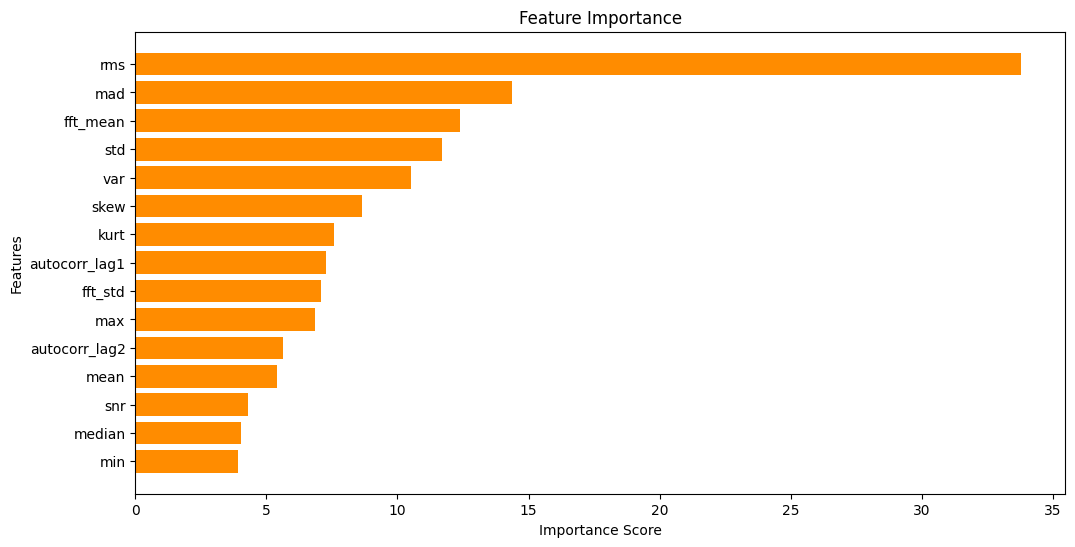

In [5]:


# Get feature importances from the XGBoost model
importance = xgb_model.get_score(importance_type='gain')

# Sort the features by importance
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Separate feature names and their importances
features, importances = zip(*sorted_importance)

# Plot the feature importance
plt.figure(figsize=(12, 6))
plt.barh(range(len(features)), importances, align='center', color='darkorange')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()



In [37]:
predictions.mean() 

0.15083185

### Load data, preprocess, extract features, train XGBoost model for the washingmachine, make predictions, and calculate AUC-ROC score

In [6]:

def extract_features(data):
    features = pd.DataFrame()
    features['mean'] = data.mean(axis=1)
    features['median'] = data.median(axis=1)
    features['std'] = data.std(axis=1)
    features['var'] = data.var(axis=1)
    features['min'] = data.min(axis=1)
    features['max'] = data.max(axis=1)
    features['skew'] = data.skew(axis=1)
    features['kurt'] = data.kurtosis(axis=1)
    features['rms'] = np.sqrt(np.mean(np.square(data), axis=1))
    features['mad'] = data.mad(axis=1)
    features['snr'] = np.where(features['std'] > 0, features['mean'] / features['std'], 0)
    features['zero_crossing_rate'] = np.mean(np.diff(np.signbit(data.values), axis=1), axis=1)
    features['autocorr_lag1'] = data.apply(lambda x: x.autocorr(lag=1), axis=1)
    features['autocorr_lag2'] = data.apply(lambda x: x.autocorr(lag=2), axis=1)

    fft_coeffs = pd.DataFrame(np.abs(fft(data.values, axis=1)))
    features['fft_mean'] = fft_coeffs.iloc[:, :5].mean(axis=1)
    features['fft_std'] = fft_coeffs.iloc[:, :5].std(axis=1)


    
    return features

# Merge the input-train and label DataFrames on the 'id' column

df = pd.merge(input_train_df, label_df, on='Index')
X = df.drop(['Index', 'Washing Machine'], axis=1)
X_features = extract_features(X)

# Split the data into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(X_features, df['Washing Machine'], test_size=0.2, random_state=42)


# Create a DMatrix for XGBoost

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
# Set the hyperparameters for XGBoost

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'map',
    'max_depth': 6,
    'eta': 0.05,
    'min_child_weight': 1,
    'subsample': 0.8,
    'seed': 42
}

# Train the XGBoost model

num_rounds = 200
xgb_model = xgb.train(params, dtrain, num_rounds, evals=[(dval, 'validation')], early_stopping_rounds=10)


df_test = pd.merge(input_test_df, label_df, on='Index') 
X_test = df_test.drop(['Index', 'Washing Machine'], axis=1)
X_test_features = extract_features(X_test)
dtest = xgb.DMatrix(X_test_features)

predictions1 = xgb_model.predict(dtest)




auc = roc_auc_score(y_val, y_pred)
print(f"AUC-ROC score: {auc}")

C:\Users\ahmed\AppData\Local\Temp\ipykernel_9768\3831300589.py:15: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  features['mad'] = data.mad(axis=1)


[0]	validation-map:0.47076
[1]	validation-map:0.50302
[2]	validation-map:0.51606
[3]	validation-map:0.52841
[4]	validation-map:0.52429
[5]	validation-map:0.52841
[6]	validation-map:0.52741
[7]	validation-map:0.52993
[8]	validation-map:0.53513
[9]	validation-map:0.54071
[10]	validation-map:0.53466
[11]	validation-map:0.54129
[12]	validation-map:0.54341
[13]	validation-map:0.54528
[14]	validation-map:0.55089
[15]	validation-map:0.55206
[16]	validation-map:0.56128
[17]	validation-map:0.56322
[18]	validation-map:0.56600
[19]	validation-map:0.57052
[20]	validation-map:0.56457
[21]	validation-map:0.56420
[22]	validation-map:0.56361
[23]	validation-map:0.56520
[24]	validation-map:0.56798
[25]	validation-map:0.56854
[26]	validation-map:0.56692
[27]	validation-map:0.56683
[28]	validation-map:0.56625
[29]	validation-map:0.56931


C:\Users\ahmed\AppData\Local\Temp\ipykernel_9768\3831300589.py:15: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  features['mad'] = data.mad(axis=1)


AUC-ROC score: 0.8078571968837456


### Load data, preprocess, extract features, train XGBoost model for the tumbledryer, make predictions, and calculate AUC-ROC score


In [7]:

def extract_features(data):
    features = pd.DataFrame()
    features['mean'] = data.mean(axis=1)
    features['median'] = data.median(axis=1)
    features['std'] = data.std(axis=1)
    features['var'] = data.var(axis=1)
    features['min'] = data.min(axis=1)
    features['max'] = data.max(axis=1)
    features['skew'] = data.skew(axis=1)
    features['kurt'] = data.kurtosis(axis=1)
    features['rms'] = np.sqrt(np.mean(np.square(data), axis=1))
    features['mad'] = data.mad(axis=1)
    features['snr'] = np.where(features['std'] > 0, features['mean'] / features['std'], 0)
    features['zero_crossing_rate'] = np.mean(np.diff(np.signbit(data.values), axis=1), axis=1)
    features['autocorr_lag1'] = data.apply(lambda x: x.autocorr(lag=1), axis=1)
    features['autocorr_lag2'] = data.apply(lambda x: x.autocorr(lag=2), axis=1)

    # FFT-based features
    fft_coeffs = pd.DataFrame(np.abs(fft(data.values, axis=1)))
    features['fft_mean'] = fft_coeffs.iloc[:, :5].mean(axis=1)
    features['fft_std'] = fft_coeffs.iloc[:, :5].std(axis=1)

    
    return features

# Merge the input-train and label DataFrames on the 'id' column

df = pd.merge(input_train_df, label_df, on='Index')
X = df.drop(['Index', 'Tumble Dryer'], axis=1)
X_features = extract_features(X)

# Split the data into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(X_features, df['Tumble Dryer'], test_size=0.2, random_state=42)


# Create a DMatrix for XGBoost

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Set the hyperparameters for XGBoost

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'map',
    'max_depth': 6,
    'eta': 0.05,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model

num_rounds = 200
xgb_model = xgb.train(params, dtrain, num_rounds, evals=[(dval, 'validation')], early_stopping_rounds=10)


df_test = pd.merge(input_test_df, label_df, on='Index') 
X_test = df_test.drop(['Index', 'Tumble Dryer'], axis=1)
X_test_features = extract_features(X_test)
dtest = xgb.DMatrix(X_test_features)

predictions2 = xgb_model.predict(dtest)






C:\Users\ahmed\AppData\Local\Temp\ipykernel_9768\2779048699.py:17: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  features['mad'] = data.mad(axis=1)


[0]	validation-map:0.41667
[1]	validation-map:0.41016
[2]	validation-map:0.41465
[3]	validation-map:0.45310
[4]	validation-map:0.44288
[5]	validation-map:0.47408
[6]	validation-map:0.46347
[7]	validation-map:0.46488
[8]	validation-map:0.46402
[9]	validation-map:0.46989
[10]	validation-map:0.47561
[11]	validation-map:0.48334
[12]	validation-map:0.48732
[13]	validation-map:0.48655
[14]	validation-map:0.48775
[15]	validation-map:0.48525
[16]	validation-map:0.48777
[17]	validation-map:0.48917
[18]	validation-map:0.48667
[19]	validation-map:0.48926
[20]	validation-map:0.49524
[21]	validation-map:0.49241
[22]	validation-map:0.49437
[23]	validation-map:0.49268
[24]	validation-map:0.49236
[25]	validation-map:0.49343
[26]	validation-map:0.49603
[27]	validation-map:0.49878
[28]	validation-map:0.49601
[29]	validation-map:0.49802
[30]	validation-map:0.49668
[31]	validation-map:0.49418
[32]	validation-map:0.49467
[33]	validation-map:0.49579
[34]	validation-map:0.49551
[35]	validation-map:0.49543
[3

C:\Users\ahmed\AppData\Local\Temp\ipykernel_9768\2779048699.py:17: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  features['mad'] = data.mad(axis=1)


### Load data, preprocess, extract features, train XGBoost model for the microwave, make predictions, and calculate AUC-ROC score

In [8]:

def extract_features(data):
    features = pd.DataFrame()
    features['mean'] = data.mean(axis=1)
    features['median'] = data.median(axis=1)
    features['std'] = data.std(axis=1)
    features['var'] = data.var(axis=1)
    features['min'] = data.min(axis=1)
    features['max'] = data.max(axis=1)
    features['skew'] = data.skew(axis=1)
    features['kurt'] = data.kurtosis(axis=1)
    features['rms'] = np.sqrt(np.mean(np.square(data), axis=1))
    features['mad'] = data.mad(axis=1)
    features['snr'] = np.where(features['std'] > 0, features['mean'] / features['std'], 0)
    features['zero_crossing_rate'] = np.mean(np.diff(np.signbit(data.values), axis=1), axis=1)
    features['autocorr_lag1'] = data.apply(lambda x: x.autocorr(lag=1), axis=1)
    features['autocorr_lag2'] = data.apply(lambda x: x.autocorr(lag=2), axis=1)

    # FFT-based features
    fft_coeffs = pd.DataFrame(np.abs(fft(data.values, axis=1)))
    features['fft_mean'] = fft_coeffs.iloc[:, :5].mean(axis=1)
    features['fft_std'] = fft_coeffs.iloc[:, :5].std(axis=1)
    
    return features
# Merge the input-train and label DataFrames on the 'id' column

df = pd.merge(input_train_df, label_df, on='Index')
X = df.drop(['Index', 'Microwave'], axis=1)
X_features = extract_features(X)

# Split the data into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(X_features, df['Microwave'], test_size=0.2, random_state=42)

# Create a DMatrix for XGBoost


dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Set the hyperparameters for XGBoost

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'map',
    'max_depth': 6,
    'eta': 0.05,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model

num_rounds = 200
xgb_model = xgb.train(params, dtrain, num_rounds, evals=[(dval, 'validation')], early_stopping_rounds=10)


df_test = pd.merge(input_test_df, label_df, on='Index') 
X_test = df_test.drop(['Index', 'Microwave'], axis=1)
X_test_features = extract_features(X_test)
dtest = xgb.DMatrix(X_test_features)

predictions3 = xgb_model.predict(dtest)








C:\Users\ahmed\AppData\Local\Temp\ipykernel_9768\1423652585.py:19: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  features['mad'] = data.mad(axis=1)


[0]	validation-map:0.37664
[1]	validation-map:0.42082
[2]	validation-map:0.42628
[3]	validation-map:0.43971
[4]	validation-map:0.45196
[5]	validation-map:0.45393
[6]	validation-map:0.45473
[7]	validation-map:0.45919
[8]	validation-map:0.45997
[9]	validation-map:0.46428
[10]	validation-map:0.46434
[11]	validation-map:0.46127
[12]	validation-map:0.46643
[13]	validation-map:0.46727
[14]	validation-map:0.46770
[15]	validation-map:0.46341
[16]	validation-map:0.46414
[17]	validation-map:0.46538
[18]	validation-map:0.46999
[19]	validation-map:0.47517
[20]	validation-map:0.47385
[21]	validation-map:0.47633
[22]	validation-map:0.47369
[23]	validation-map:0.47429
[24]	validation-map:0.47532
[25]	validation-map:0.47489
[26]	validation-map:0.47220
[27]	validation-map:0.47047
[28]	validation-map:0.47332
[29]	validation-map:0.47465
[30]	validation-map:0.47312


C:\Users\ahmed\AppData\Local\Temp\ipykernel_9768\1423652585.py:19: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  features['mad'] = data.mad(axis=1)


### Load data, preprocess, extract features, train XGBoost model for the kettle, make predictions, and calculate AUC-ROC score

In [9]:

def extract_features(data):
    features = pd.DataFrame()
    features['mean'] = data.mean(axis=1)
    features['median'] = data.median(axis=1)
    features['std'] = data.std(axis=1)
    features['var'] = data.var(axis=1)
    features['min'] = data.min(axis=1)
    features['max'] = data.max(axis=1)
    features['skew'] = data.skew(axis=1)
    features['kurt'] = data.kurtosis(axis=1)
    features['rms'] = np.sqrt(np.mean(np.square(data), axis=1))
    features['mad'] = data.mad(axis=1)
    features['snr'] = np.where(features['std'] > 0, features['mean'] / features['std'], 0)
    features['zero_crossing_rate'] = np.mean(np.diff(np.signbit(data.values), axis=1), axis=1)
    features['autocorr_lag1'] = data.apply(lambda x: x.autocorr(lag=1), axis=1)
    features['autocorr_lag2'] = data.apply(lambda x: x.autocorr(lag=2), axis=1)
    fft_coeffs = pd.DataFrame(np.abs(fft(data.values, axis=1)))
    features['fft_mean'] = fft_coeffs.iloc[:, :5].mean(axis=1)
    features['fft_std'] = fft_coeffs.iloc[:, :5].std(axis=1)
   
    
    return features

# Merge the input-train and label DataFrames on the 'id' column

df = pd.merge(input_train_df, label_df, on='Index')
X = df.drop(['Index', 'Kettle'], axis=1)
X_features = extract_features(X)

# Split the data into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(X_features, df['Kettle'], test_size=0.2, random_state=42)

# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
# Set the hyperparameters for XGBoost

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'map',
    'max_depth': 6,
    'eta': 0.05,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model
num_rounds = 200
xgb_model = xgb.train(params, dtrain, num_rounds, evals=[(dval, 'validation')], early_stopping_rounds=10)

df_test = pd.merge(input_test_df, label_df, on='Index') 
X_test = df_test.drop(['Index', 'Kettle'], axis=1)
X_test_features = extract_features(X_test)
dtest = xgb.DMatrix(X_test_features)

predictions4 = xgb_model.predict(dtest)









C:\Users\ahmed\AppData\Local\Temp\ipykernel_9768\3741148908.py:17: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  features['mad'] = data.mad(axis=1)


[0]	validation-map:0.75673
[1]	validation-map:0.77490
[2]	validation-map:0.77878
[3]	validation-map:0.78449
[4]	validation-map:0.79581
[5]	validation-map:0.79905
[6]	validation-map:0.79918
[7]	validation-map:0.79975
[8]	validation-map:0.81336
[9]	validation-map:0.81245
[10]	validation-map:0.81228
[11]	validation-map:0.81807
[12]	validation-map:0.82032
[13]	validation-map:0.82102
[14]	validation-map:0.82142
[15]	validation-map:0.82171
[16]	validation-map:0.82284
[17]	validation-map:0.82288
[18]	validation-map:0.82367
[19]	validation-map:0.82435
[20]	validation-map:0.82507
[21]	validation-map:0.82703
[22]	validation-map:0.82721
[23]	validation-map:0.82696
[24]	validation-map:0.82822
[25]	validation-map:0.82875
[26]	validation-map:0.82876
[27]	validation-map:0.82941
[28]	validation-map:0.83079
[29]	validation-map:0.83112
[30]	validation-map:0.83184
[31]	validation-map:0.83304
[32]	validation-map:0.83357
[33]	validation-map:0.83480
[34]	validation-map:0.83535
[35]	validation-map:0.83635
[3

C:\Users\ahmed\AppData\Local\Temp\ipykernel_9768\3741148908.py:17: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  features['mad'] = data.mad(axis=1)


### Create a DataFrame containing predictions for each appliance and display it

In [10]:
mydf = pd.DataFrame(list(zip(predictions, predictions1,predictions2,predictions3,predictions4)),
               columns =['Dishwasher', 'Washing Machine','Tumble Dryer','Microwave','Kettle'])
mydf

,Dishwasher,Washing Machine,Tumble Dryer,Microwave,Kettle
0,0.025244,0.319115,0.092017,0.227374,0.407473
1,0.044267,0.324496,0.093494,0.197203,0.193196
2,0.629706,0.462856,0.182738,0.399608,0.303138
3,0.004807,0.196160,0.090704,0.222439,0.202572
4,0.039782,0.176875,0.085129,0.214092,0.247196
...,...,...,...,...,...
2483,0.595825,0.121360,0.080048,0.120281,0.029325
2484,0.595825,0.121360,0.080048,0.120281,0.029325
2485,0.595825,0.121360,0.080048,0.120281,0.029325
2486,0.595825,0.121360,0.080048,0.120281,0.029325


### Create and display box plots of prediction probabilities for each appliance using seaborn

C:\Users\ahmed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


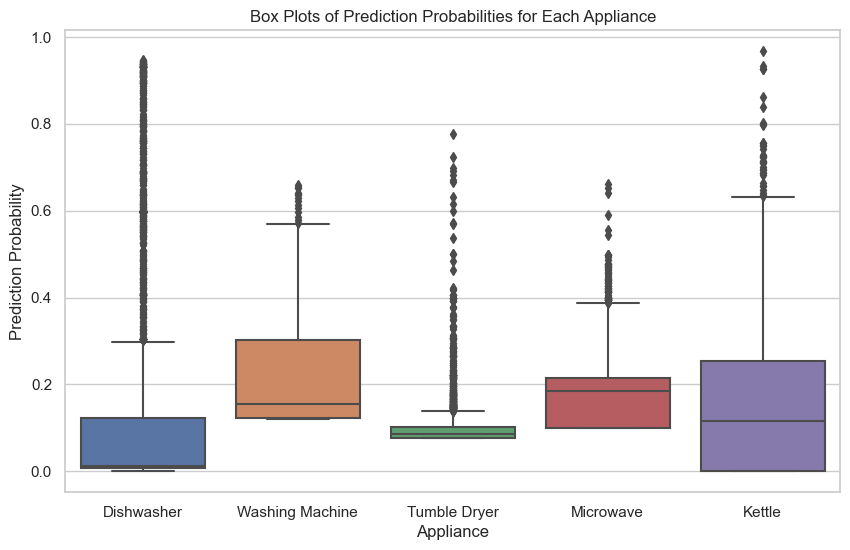

In [12]:


# Create box plots for each appliance
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data=mydf)
plt.title("Box Plots of Prediction Probabilities for Each Appliance")
plt.xlabel("Appliance")
plt.ylabel("Prediction Probability")
plt.show()


### Save the DataFrame as a CSV file

In [14]:
mydf.to_csv('C:/Users/ahmed/OneDrive/Bureau/DCI MASTER S2/datasets/test_final5.csv')